In [3]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [154]:


def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, seq_length = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)
    
    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    # Split the data based on 60/20/20 ratio
    train_size = int(0.6 * n_sequences)
    val_size = int(0.2 * n_sequences)
    
    train_data = tokenized_sequences[:train_size]  # First 60% of sequences for training
    val_data = tokenized_sequences[train_size:train_size + val_size]  # Next 20% for validation
    test_data = tokenized_sequences[train_size + val_size:]  # Remaining 20% for testing

    print('Number of Tokens:', num_bins)
    print('Training Data Shape:', train_data.shape)
    print('Validation Data Shape:', val_data.shape)
    print('Test Data Shape:', test_data.shape)

    return train_data, val_data, test_data, num_bins

def plot_price_hist(price, deltas, bin_start, bin_stop, bin_width):
    fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

    # Histogram: GBM Prices
    axs[0].hist(np.concatenate(price), bins=20, color='blue', density=True)
    axs[0].set_title('Histogram: AR Prices')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')

    bins = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Histogram: GBM Price Deltas
    axs[1].hist(np.concatenate(deltas), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    axs[1].set_title('Histogram: AR Price Deltas')
    axs[1].set_xlabel('Price Difference')
    axs[1].set_ylabel('Frequency')

    # Boxplot Price Deltas
    axs[2].boxplot(np.concatenate(deltas), vert=False)
    axs[2].set_title('Boxplot Price Deltas')
    axs[2].set_xlabel('Price Difference')
    plt.tight_layout()
    plt.show()


def calculate_entropy(sequence):
    
    # Get unique values and their counts in one pass
    values, counts = np.unique(sequence, return_counts=True)
    
    # Calculate probabilities using vectorized operation
    probabilities = counts / len(sequence)
    
    # Calculate entropy vectorized with numerical stability
    # Using log(p) directly is stable when p > 0
    entropy = -np.sum(probabilities * np.log(probabilities))
    
    return entropy

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func


def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_rewards(ep_rew, kl_div, ep_len=None):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Model Update')
    #axs[0].set_ylim(-12,0)

    axs[1].plot(ep_len, color='blue')
    axs[1].set_title('Episode Length')
    axs[1].set_ylabel('Length')
    axs[1].set_xlabel('Episode')

    axs[2].plot(kl_div, color='blue')
    axs[2].set_title('KL Div. real vs. sim sequences')
    axs[2].set_ylabel('KL Divergence')
    axs[2].set_xlabel('Model Update')

    plt.show()

def plot_discriminator(wasserstein, disc_acc, disc_loss):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()

    axs[0].plot(wasserstein, color='blue')
    axs[0].set_title('Wasserstein Distance')
    axs[0].set_ylabel('WS Distance')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(disc_acc, color='blue')
    axs[1].axhline(0.5, color='red', linestyle='--', linewidth=1)
    axs[1].set_title('Discriminator Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylim(0,1)

    axs[2].plot(disc_loss, color='blue')
    axs[2].set_title('Discriminator Loss')
    axs[2].set_ylabel('Loss')
    axs[2].set_xlabel('Model Update')

    plt.show()


def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
    
    return means, variances, std_devs, skewness, kurtos

def plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))

    # Plot 1: Mean Distribution
    axs[0].hist(gail_means, bins=bin_edges_mean, alpha=0.8, label='GAIL', color='green')
    axs[0].hist(supervised_means, bins=bin_edges_mean, alpha=0.8, label='Supervised', color='red')
    axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Mean')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].set_ylim(0,1800)

    # Plot 1: Variance Distribution
    axs[1].hist(gail_variances, bins=bin_edges_var, alpha=0.8, label='GAIL', color='green')
    axs[1].hist(supervised_variances, bins=bin_edges_var, alpha=0.8, label='Supervised', color='red')
    axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Value')
    axs[1].set_ylim(0,1800)
    axs[1].tick_params(labelleft=False)

    # Plot 2: Skewness Distribution
    axs[2].hist(gail_skew, bins=bin_edges_skew, alpha=0.8, label='GAIL', color='green')
    axs[2].hist(supervised_skew, bins=bin_edges_skew, alpha=0.8, label='Supervised', color='red')
    axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Skewness')
    axs[2].set_xlabel('Value')
    axs[2].set_ylim(0,1800)
    axs[2].tick_params(labelleft=False)
    plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
    plt.tight_layout()
    plt.show()  

def plot_sequences(real_seq, supervised, gail):
    # Create the subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
    axes = axes.flatten()

    # Plot the real and simulated trajectories
    for i in range(3):
        axes[i].plot(real_seq[i][1:], label='Real Trajectory', color='skyblue')
        axes[i].plot(supervised[i], label='Supervised', color='red')
        axes[i].plot(gail[i], label='GAIL', color='green')
        axes[i].legend(loc='best')
        axes[i].set_title(f'Trajectory {i+1}')
        axes[i].set_ylim(0, 50)
        axes[i].set_xlabel('Time Step')
        
        if i == 0:  # Only set y-axis label on the first plot
            axes[i].set_ylabel('Price Delta')
        else:
            axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

    # Adjust spacing between plots to bring them closer
    plt.subplots_adjust(wspace=0)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def wasserstein_dist(real_sequences, supervised, gail):

    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    wasserstein_gail = []

    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], supervised[:, t])
        wasserstein_supervised.append(w_dist)
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], gail[:, t])
        wasserstein_gail.append(w_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 3.5))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 3)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.plot(wasserstein_gail, label = 'GAIL')
    ax1.legend()
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_supervised]
    generated_data = supervised[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()

    # Plot 3: Compare specific timesteps
    ax3 = fig.add_subplot(gs[0, 2])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_gail = np.argmax(wasserstein_gail)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_gail]
    generated_data = gail[:, worst_timestep_gail]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax3.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax3.plot(x_eval, kde_generated(x_eval), label='GAIL', color='green')
    ax3.set_title(f'Distribution Comparison at Timestep {worst_timestep_gail}\n'
                f'(Largest Wasserstein Distance)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

def calculate_acf(trajectories, nlags):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

def calculate_pacf(trajectories, nlags):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

def plot_acf_pacf(real_sequences, supervised, gail):

    nlags_acf = len(real_sequences[0])-1
    nlags_pacf = int(len(real_sequences[0])/2-2)
    
    # ACFs for real and simulated trajectories
    real_acfs = calculate_acf([real_sequences[i] for i in range(len(real_sequences))], nlags=nlags_acf)
    avg_real_acf = np.mean(real_acfs, axis=0)
    
    supervised_acfs = calculate_acf([supervised[i] for i in range(len(supervised))], nlags=nlags_acf)
    avg_supervised_acf = np.mean(supervised_acfs, axis=0)

    gail_acfs = calculate_acf([gail[i] for i in range(len(gail))], nlags=nlags_acf)
    avg_gail_acf = np.mean(gail_acfs, axis=0)

    # Calculate PACFs for real and simulated trajectories
    real_pacfs = calculate_pacf([real_sequences[i][1:] for i in range(len(real_sequences))], nlags=nlags_pacf)
    avg_real_pacf = np.mean(real_pacfs, axis=0)
    
    supervised_pacfs = calculate_pacf([supervised[i] for i in range(len(supervised))], nlags=nlags_pacf)
    avg_supervised_pacf = np.mean(supervised_pacfs, axis=0)

    gail_pacfs = calculate_pacf([gail[i] for i in range(len(gail))], nlags=nlags_pacf)
    avg_gail_pacf = np.mean(gail_pacfs, axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Plot the averaged ACFs
    axs[0].plot(avg_real_acf, label='Real', color='blue')
    axs[0].plot(avg_supervised_acf, label='Supervised', color='red')
    axs[0].plot(avg_gail_acf, label='GAIL', color='green')
    axs[0].set_title('Average Autocorrelation Function')
    axs[0].set_xlabel('Lag')
    axs[0].set_ylabel('Autocorrelation')
    #axs[0].set_xticks(np.arange(0, nlags_acf, 1))
    axs[0].legend()

    # Plot the averaged PACFs
    axs[1].plot(avg_real_pacf, label='Real', color='blue')
    axs[1].plot(avg_supervised_pacf, label='Supervised', color='red')
    axs[1].plot(avg_gail_pacf, label='GAIL', color='green')
    axs[1].set_title('Average Partial Autocorrelation Function')
    axs[1].set_xlabel('Lag')
    axs[1].set_ylabel('Partial Autocorrelation')
    #axs[1].set_xticks(np.arange(0, nlags_pacf, 1))
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def distribution_evolution(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histogram for each timestep
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    # Define common range for all histograms
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max for color scaling
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create visualization
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()

def distribution_evolution1(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histograms (same as before)
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create custom normalization to enhance color contrast
    # Option 1: Using power-law normalization
    from matplotlib.colors import PowerNorm
    norm = PowerNorm(gamma=0.5)  # gamma < 1 will enhance lower values
    
    # Option 2: Alternative - use LogNorm for even more contrast
    # from matplotlib.colors import LogNorm
    # norm = LogNorm(vmin=max(vmin, 0.001), vmax=vmax)  # avoid log(0)
    
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()




#### KANGS VOLATILITY FUNCTION

a. **Volatility:** $\quad$ $\quad$ $\quad$ $\quad$ $\quad$  $\sigma_t = ax_{t-1}+b\sigma_{t-1}$

b. **Random Perturbation:** $\quad$ $\epsilon_t \sim N(0,1)$

c. **Increment and limit:** $\quad$ $\quad$ $\Delta x_t = \text{clip}(\sigma_t\epsilon_t, -2\sigma_t, 2\sigma_t)$

d. **Update Position:** $\quad$ $\quad$ $\quad$ $x_t = x_{t-1} + \theta(\mu - x_{t-1}) + \Delta x_t$

e. **Record:** $\quad$ $\quad$ $\quad$ $\quad$  $\quad$ $\quad$ $x_t$ and $\sigma_t$

In [ ]:
def generate_modified_mean_reversion(x0, sigma0, theta, mu, a, b, T, N, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
        
    x = np.zeros((N, T))
    sigma = np.zeros((N, T))
    
    x_prev = np.full(N, x0)
    sigma_prev = np.full(N, sigma0)
    
    for t in range(T):
        sigma_t = a * np.abs(x_prev) + b * sigma_prev
        # Add maximum cap on volatility
        sigma_t = np.clip(sigma_t, 1e-6, 2.0)
        
        epsilon_t = np.random.normal(0, 1, N)
        delta_x = sigma_t * epsilon_t
        # Stricter clip limits
        delta_x = np.clip(delta_x, -2*sigma_t, 2*sigma_t)
        
        x_t = x_prev + theta * (mu - x_prev) + delta_x
        
        x[:, t] = x_t
        sigma[:, t] = sigma_t
        
        x_prev = x_t
        sigma_prev = sigma_t
    
    deltas = np.diff(x, axis=1) / x[:, :-1]
    return x, deltas

In [167]:
x0 = 0.0
sigma0 = 1.0
theta = 0.05
mu = 0.0
a = 0.1             # Coefficient of volatility dependence on position
b = 0.80            # Coefficient of volatility dependence on historical volatility
n_days = 27         # Number of time steps
n_sequences = 50000

Price_Kang, Delta_Kang = generate_modified_mean_reversion(x0, sigma0, theta, mu, a, b, T=n_days, N=n_sequences)

In [168]:
delta_quantiles = np.percentile(np.concatenate(Delta_Kang), [10, 25, 50, 75, 90, 95, 99])
print("\nDelta Quantiles:")
print(f"10th percentile: {delta_quantiles[0]}")
print(f"25th percentile: {delta_quantiles[1]}")
print(f"50th percentile (median): {delta_quantiles[2]}")
print(f"75th percentile: {delta_quantiles[3]}")
print(f"90th percentile: {delta_quantiles[4]}")
print(f"95th percentile: {delta_quantiles[5]}")
print(f"99th percentile: {delta_quantiles[6]}")


Delta Quantiles:
10th percentile: -1.1376923131138919
25th percentile: -0.5080484549274593
50th percentile (median): -0.048111818353008304
75th percentile: 0.4104376580785554
90th percentile: 1.0416928004091681
95th percentile: 2.0679120362722028
99th percentile: 10.535550266165783


Standard Deviation of Price Deltas: 294.946
BIN WIDTH:  0.08
Number of Tokens: 50
Training Data Shape: (30000, 26)
Validation Data Shape: (10000, 26)
Test Data Shape: (10000, 26)


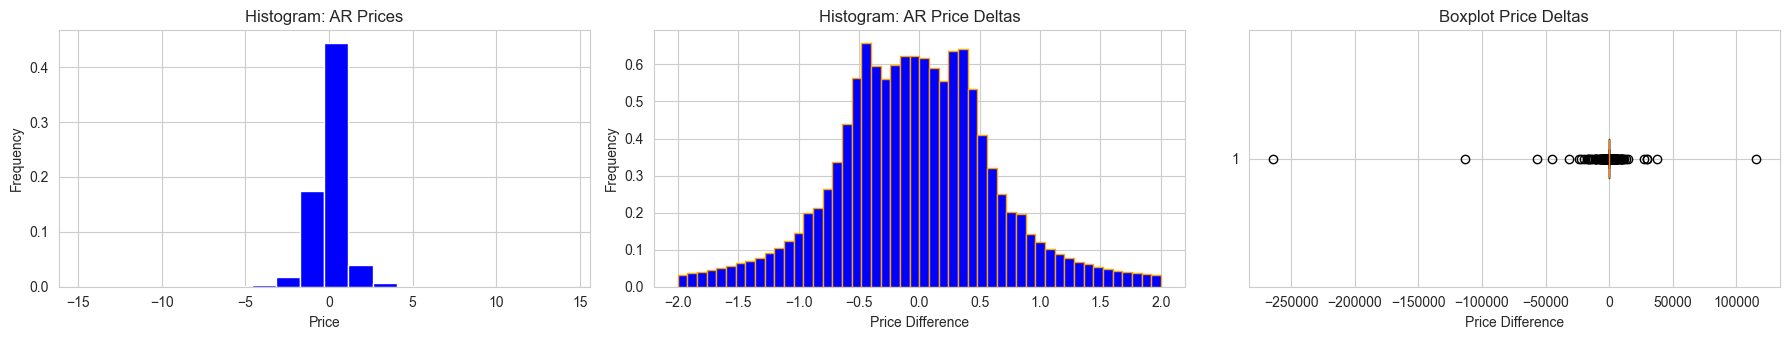

In [169]:
bin_width = 0.08
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(Delta_Kang)),3))
print('BIN WIDTH: ', bin_width)
bin_start=-2
bin_stop=2

train_data, val_data, test_data, token_size = tokenize_deltas(Delta_Kang, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

plot_price_hist(Price_Kang, Delta_Kang, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

In [111]:
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(Delta_Kang)),3))

Standard Deviation of Price Deltas: 278.237


#### HESTON MODEL

a. **Correlated Normals:** $\quad$ $\quad$ $Z_1 \sim N(0,1)$, $Z_2 = \rho Z_1 + \sqrt{1-\rho^2}\epsilon$, $\epsilon \sim N(0,1)$

b. **Variance Process:** $\quad$ $\quad$ $v_t = \max(v_{t-1} + \kappa(\theta - v_{t-1})dt + \sigma\sqrt{v_{t-1}}Z_1\sqrt{dt}, 10^{-10})$

c. **Price Process:** $\quad$ $\quad$ $\quad$ $S_t = S_{t-1}\exp(\sqrt{v_{t-1}}Z_2\sqrt{dt} - 0.5v_{t-1}dt)$

d. **Record:** $\quad$ $\quad$ $\quad$ $\quad$ $\quad$ $S_t$ and $v_t$

In [34]:
def generate_heston_sequences(S0, v0, kappa, theta, sigma, rho, T, N, dt=1/252):
    steps = int(T/dt)
    sqrt_dt = np.sqrt(dt)
    
    prices = np.zeros((N, steps))
    vols = np.zeros((N, steps))
    
    prices[:, 0] = S0
    vols[:, 0] = v0
    
    for t in range(1, steps):
        Z1 = np.random.normal(0, 1, N)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, N)
        
        vols[:, t] = np.maximum(
            vols[:, t-1] + kappa * (theta - vols[:, t-1]) * dt + 
            sigma * np.sqrt(vols[:, t-1]) * Z1 * sqrt_dt, 
            1e-10
        )
        
        prices[:, t] = prices[:, t-1] * np.exp(
            np.sqrt(vols[:, t-1]) * Z2 * sqrt_dt - 0.5 * vols[:, t-1] * dt
        )
    
    deltas = np.diff(prices, axis=1) / prices[:, :-1]
    return prices, deltas

In [57]:
def generate_complex_sequences(S0, v0, kappa, theta, sigma, rho, T, N, dt=1/252):
    steps = int(T/dt)
    sqrt_dt = np.sqrt(dt)
    
    prices = np.zeros((N, steps))
    vols = np.zeros((N, steps))
    
    prices[:, 0] = S0
    vols[:, 0] = v0
    
    # Add regime switching
    regime_change = np.random.binomial(1, 0.1, (N, steps))
    regime_theta = np.where(regime_change == 1, theta * 2, theta)
    
    # Add jumps
    jumps = np.random.binomial(1, 0.05, (N, steps)) * np.random.normal(0, 0.02, (N, steps))
    
    for t in range(1, steps):
        Z1 = np.random.normal(0, 1, N)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, N)
        
        vols[:, t] = np.maximum(
            vols[:, t-1] + kappa * (regime_theta[:, t] - vols[:, t-1]) * dt + 
            sigma * np.sqrt(vols[:, t-1]) * Z1 * sqrt_dt, 
            1e-10
        )
        
        prices[:, t] = prices[:, t-1] * np.exp(
            np.sqrt(vols[:, t-1]) * Z2 * sqrt_dt - 
            0.5 * vols[:, t-1] * dt + 
            jumps[:, t]
        )
    
    deltas = np.diff(prices, axis=1) / prices[:, :-1]
    return prices, deltas

In [72]:
def generate_complex_sequences(S0, v0, kappa, theta, sigma, rho, T, N, dt=1/252):
    steps = int(T/dt)
    sqrt_dt = np.sqrt(dt)
    prices = np.zeros((N, steps))
    vols = np.zeros((N, steps))
    
    # Add multiple regimes
    n_regimes = 3
    regime_thetas = np.array([theta * 0.5, theta, theta * 2.0])
    regime_sigmas = np.array([sigma * 0.5, sigma, sigma * 1.5])
    
    # Markov transition matrix for regimes
    transition_probs = np.array([[0.95, 0.025, 0.025],
                               [0.025, 0.95, 0.025],
                               [0.025, 0.025, 0.95]])
    
    current_regime = np.random.randint(0, n_regimes, N)
    prices[:, 0] = S0
    vols[:, 0] = v0
    
    for t in range(1, steps):
        # Apply Markov transitions
        for i in range(N):
            current_regime[i] = np.random.choice(n_regimes, p=transition_probs[current_regime[i]])
        
        current_theta = regime_thetas[current_regime]
        current_sigma = regime_sigmas[current_regime]
        
        # Stochastic kappa
        kappa_t = kappa * (1 + 0.2 * np.random.normal(0, 1, N))
        
        Z1 = np.random.normal(0, 1, N)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, N)
        
        # Add occasional jumps
        jumps = np.random.binomial(1, 0.05, N) * np.random.normal(0, 0.02, N)
        
        vols[:, t] = np.maximum(
            vols[:, t-1] + kappa_t * (current_theta - vols[:, t-1]) * dt + 
            current_sigma * np.sqrt(vols[:, t-1]) * Z1 * sqrt_dt, 
            1e-10
        )
        
        prices[:, t] = prices[:, t-1] * np.exp(
            np.sqrt(vols[:, t-1]) * Z2 * sqrt_dt - 
            0.5 * vols[:, t-1] * dt + jumps
        )
    
    deltas = np.diff(prices, axis=1) / prices[:, :-1]
    return prices, deltas

Standard Deviation of Price Deltas: 0.014
BIN WIDTH:  0.003
Number of Tokens: 66
Training Data Shape: (30000, 49)
Validation Data Shape: (10000, 49)
Test Data Shape: (10000, 49)


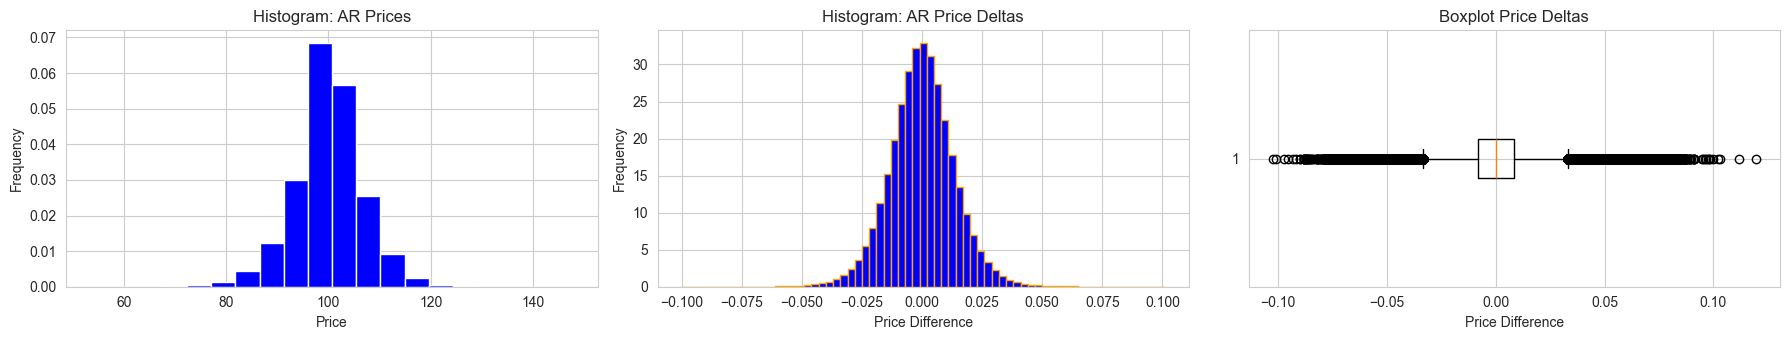

In [74]:
# Initial conditions
S0 = 100  
v0 = 0.04

# Model parameters
kappa = 2.0   
theta = 0.04  
sigma = 0.3   
rho = -0.7    

# Simulation parameters
T = 50/252    # 25 trading days
N = 50000     # Number of sequences
dt = 1/252    # Daily steps

Price_Kang, Delta_Kang = generate_complex_sequences(S0, v0, kappa, theta, sigma, rho, T, N)

bin_width = 0.003
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(Delta_Kang)),3))
print('BIN WIDTH: ', bin_width)
bin_start=-0.10
bin_stop=0.10

train_data, val_data, test_data, token_size = tokenize_deltas(Delta_Kang, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

plot_price_hist(Price_Kang, Delta_Kang, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

Standard Deviation of Price Deltas: 0.133
BIN WIDTH:  0.035
Number of Tokens: 85
Training Data Shape: (30000, 49)
Validation Data Shape: (10000, 49)
Test Data Shape: (10000, 49)


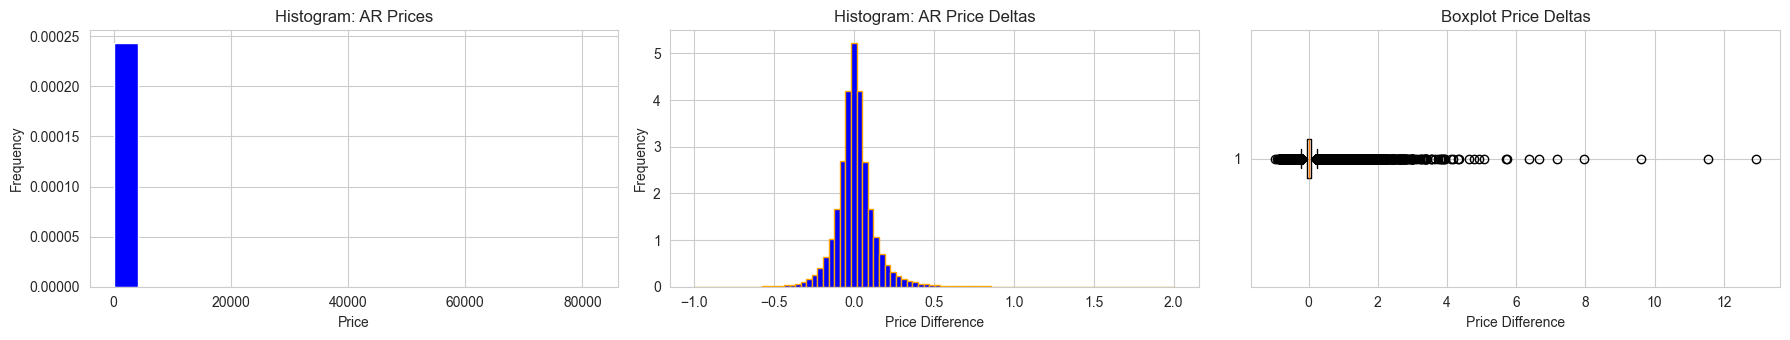

In [97]:
def generate_mrw_sequences(T, N, L=50, lambda_=0.4, sigma=1.0, seed=None):
    """
    Generate Multifractal Random Walk sequences with improved numerical stability
    
    Parameters:
    - T: Length of each sequence
    - N: Number of sequences
    - L: Integral scale (correlation length)
    - lambda_: Intermittency parameter (controls multifractality)
    - sigma: Base volatility
    - seed: Random seed for reproducibility
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = 1
    prices = np.zeros((N, T))
    
    # Generate correlation kernel with better numerical stability
    def generate_kernel(t, L, lambda_):
        # Using log(L/(|t|+1)) instead of log(L/|t|) for stability
        t = np.abs(t)
        kernel = np.where(t == 0, 
                         lambda_**2 * np.log(L),
                         lambda_**2 * np.maximum(0, np.log(L/(t+1))))
        return kernel
    
    # Create time differences matrix
    t_diff = np.abs(np.arange(T)[:, None] - np.arange(T))
    
    # Construct correlation matrix with regularization
    corr_matrix = generate_kernel(t_diff, L, lambda_)
    # Add small regularization term to ensure positive definiteness
    corr_matrix += 1e-6 * np.eye(T)
    
    for n in range(N):
        try:
            # Generate multivariate normal with given correlation
            omega = np.random.multivariate_normal(np.zeros(T), corr_matrix)
            
            # Normalize to ensure E[e^w] = 1
            omega = omega - np.var(omega)/2
            
            # Generate returns
            epsilon = np.random.normal(0, 1, T)
            returns = sigma * np.exp(omega) * epsilon * np.sqrt(dt)
            
            # Convert to prices
            prices[n,0] = 100  # Starting price
            prices[n,1:] = prices[n,0] * np.exp(np.cumsum(returns[1:]))
            
        except np.linalg.LinAlgError:
            # If still fails, use more regularization
            print(f"Retrying sequence {n} with more regularization...")
            corr_matrix_reg = corr_matrix + 1e-4 * np.eye(T)
            omega = np.random.multivariate_normal(np.zeros(T), corr_matrix_reg)
            omega = omega - np.var(omega)/2
            epsilon = np.random.normal(0, 1, T)
            returns = sigma * np.exp(omega) * epsilon * np.sqrt(dt)
            prices[n,0] = 100
            prices[n,1:] = prices[n,0] * np.exp(np.cumsum(returns[1:]))
    
    deltas = np.diff(prices, axis=1) / prices[:, :-1]
    return prices, deltas

# Usage with more stable parameters:
T = 50  # sequence length
N = 50000  # number of sequences
lambda_ = 0.3  # reduced intermittency for stability (try 0.2-0.4)
L = 50  # correlation length
sigma = 0.1  # base volatility

Price_Kang, Delta_Kang = generate_mrw_sequences(T, N, L, lambda_, sigma)

bin_width = 0.035
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(Delta_Kang)),3))
print('BIN WIDTH: ', bin_width)
bin_start=-1
bin_stop=2

train_data, val_data, test_data, token_size = tokenize_deltas(Delta_Kang, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

plot_price_hist(Price_Kang, Delta_Kang, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

### Supervised Learning


In [170]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # LSTM Layer with 2 layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # LSTM Layer (with 2 stacked layers)
        # x shape should be: [batch_size, sequence_length, input_dim]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)      # Shape: [batch_size, sequence_length, hidden_dim]
        
        # Apply Fully Connected Layer to each time step
        logits = self.fc(lstm_out)                       # Shape: [batch_size, sequence_length, output_dim]

        return logits, (h_n, c_n)                        # Return predictions for each time step

In [171]:
hidden_dim = 256                 # Hidden Dimension
batch_size = 512                # Batch Size
learning_rate = 0.001           # LR
seq_len = len(train_data[0])    # Length of your tokenized sequences
num_epochs = 20                 # Number of epochs to train

In [172]:
model_supervised = LSTMModel(input_dim=1, hidden_dim=hidden_dim, output_dim=token_size)

criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):

    temp_train_loss = []
    temp_val_loss = []
    
    ## ============
    ## TRAINING
    ## ============

    # Shuffle the data at the beginning of the epoch
    indices = np.arange(len(train_data))
    np.random.shuffle(indices)

    for batch_idx in range(0, len(train_data), batch_size):
        model_supervised.train()
        
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = train_data[batch_indices]
        
        inputs = th.tensor(batch[:, :-1], dtype=th.float32).unsqueeze(-1)
        targets = th.tensor(batch[:, 1:], dtype=th.long)
        
        # Forward pass for this batch
        logits, _ = model_supervised(inputs, None)
        logits = logits.view(-1, logits.size(-1))  # Flatten logits: (batch_size * seq_len, num_bins)
        targets = targets.view(-1)                 # Flatten targets: (batch_size * seq_len)
        
        loss = criterion_supervised(logits, targets)
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the model parameters
        
        
        temp_train_loss.append(loss.item())
        
        ## ============
        ## VALIDATION
        ## ============

        model_supervised.eval()
        
        with th.no_grad():
            inputs = th.tensor(val_data[:, :-1], dtype=th.float32).unsqueeze(-1)  # All tokens except the last
            targets = th.tensor(val_data[:, 1:], dtype=th.long)  # All tokens except the first
            logits, _ = model_supervised(inputs, None)
            logits = logits.view(-1, logits.size(-1))  # Flatten logits: (batch_size * seq_len, num_bins)
            targets = targets.view(-1)                 # Flatten targets: (batch_size * seq_len)
            loss = criterion_supervised(logits, targets)
            temp_val_loss.append(loss.item())
        
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            th.save(model_supervised.state_dict(), 'supervised_weights_AR.pth')
    
    train_losses.extend(temp_train_loss)
    val_losses.extend(temp_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {np.mean(temp_val_loss):.4f}")

Epoch 1/20 - Train Loss: 3.4268 - Val Loss: 3.4154
Epoch 2/20 - Train Loss: 3.2165 - Val Loss: 3.2147
Epoch 3/20 - Train Loss: 3.1412 - Val Loss: 3.1413
Epoch 4/20 - Train Loss: 3.1029 - Val Loss: 3.1031
Epoch 5/20 - Train Loss: 3.0772 - Val Loss: 3.0776
Epoch 6/20 - Train Loss: 3.0589 - Val Loss: 3.0592
Epoch 7/20 - Train Loss: 3.0437 - Val Loss: 3.0439
Epoch 8/20 - Train Loss: 3.0349 - Val Loss: 3.0355
Epoch 9/20 - Train Loss: 3.0238 - Val Loss: 3.0241
Epoch 10/20 - Train Loss: 3.0174 - Val Loss: 3.0182
Epoch 11/20 - Train Loss: 3.0105 - Val Loss: 3.0114
Epoch 12/20 - Train Loss: 3.0036 - Val Loss: 3.0044
Epoch 13/20 - Train Loss: 3.0029 - Val Loss: 3.0040
Epoch 14/20 - Train Loss: 2.9961 - Val Loss: 2.9974
Epoch 15/20 - Train Loss: 2.9924 - Val Loss: 2.9938
Epoch 16/20 - Train Loss: 2.9875 - Val Loss: 2.9889
Epoch 17/20 - Train Loss: 2.9848 - Val Loss: 2.9861
Epoch 18/20 - Train Loss: 2.9817 - Val Loss: 2.9832
Epoch 19/20 - Train Loss: 2.9777 - Val Loss: 2.9796
Epoch 20/20 - Train L

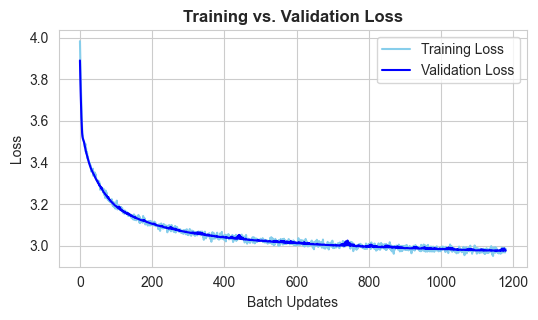

In [173]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_losses, label='Training Loss', color='skyblue', linewidth=1.5)
plt.plot(val_losses, label='Validation Loss', color='blue', linewidth=1.5)
plt.title('Training vs. Validation Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

In [174]:
inference_model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, output_dim=token_size)
inference_model.load_state_dict(th.load('supervised_weights_AR.pth', weights_only=False))

test_data_inference = th.tensor(test_data, dtype=th.float32)

test_losses = []
supervised_data = []

inference_model.eval()

with th.no_grad():
    
    for sequence in test_data_inference:

        token_loss = 0

        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        hidden = None
        
        for i in range(1, len(sequence)):

            input = sim_trajectory[-1].reshape(1, 1, 1)

            logits, hidden = inference_model(input, hidden)

            probs = F.softmax(logits, dim=-1).squeeze()
            predicted_token = th.multinomial(probs, num_samples=1).squeeze()
            
            sim_trajectory.append(predicted_token.float())

            # Loss
            true_token = sequence[i].unsqueeze(-1)

            loss = criterion_supervised(logits.squeeze(1), true_token.long())
            token_loss += loss.item()

        test_losses.append(token_loss/len(sequence))
        supervised_data.append(sim_trajectory[1:])

supervised_data = np.array(supervised_data)

In [175]:
real_means, real_variances, real_std_devs, real_skew, real_kurtosis = calculate_statistics(val_data[:,1:])
supervised_means, supervised_variances, supervised_std_devs, supervised_skew, supervised_kurtosis = calculate_statistics(supervised_data)
gail_means, gail_variances, gail_std_devs, gail_skew, gail_kurtosis = calculate_statistics(supervised_data)

bin_start_mean = min(np.min(supervised_means), np.min(real_means))
bin_stop_mean = max(np.max(supervised_means), np.max(real_means))
bin_start_var = min(np.min(supervised_variances), np.min(real_variances))
bin_stop_var = max(np.max(supervised_variances), np.max(real_variances))
bin_start_skew = min(np.min(supervised_skew), np.min(real_skew))
bin_stop_skew = max(np.max(supervised_skew), np.max(real_skew))

bin_width_mean = 0.4
bin_width_var = 12
bin_width_skew = 0.20

bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

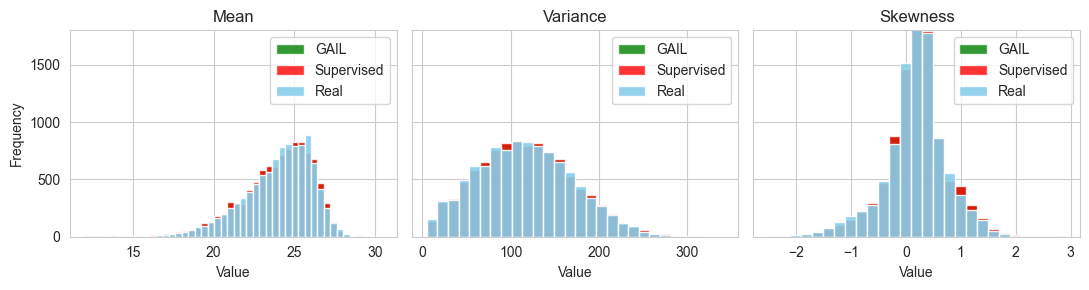

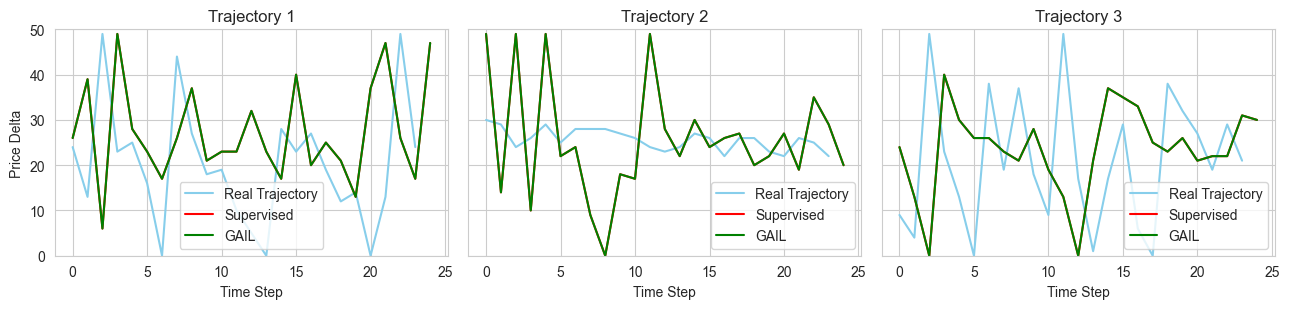

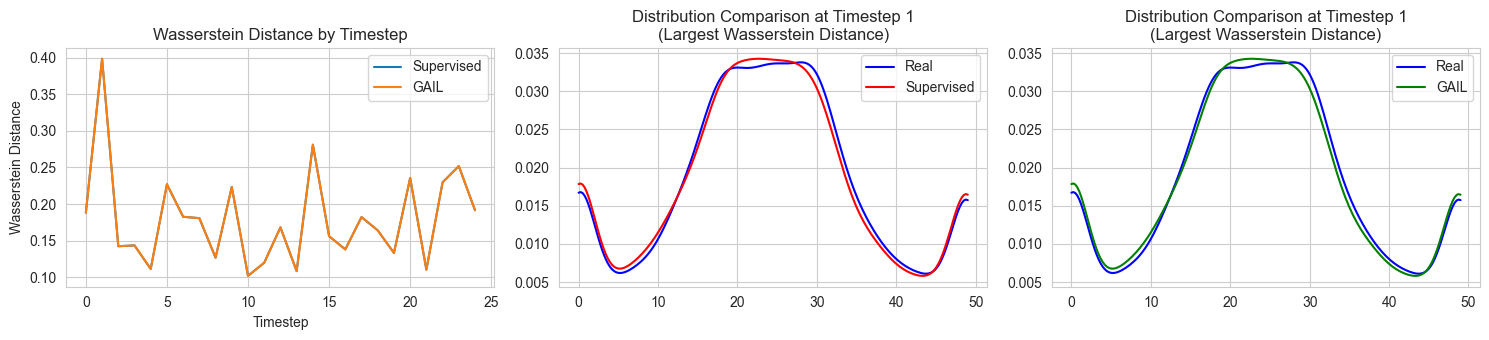

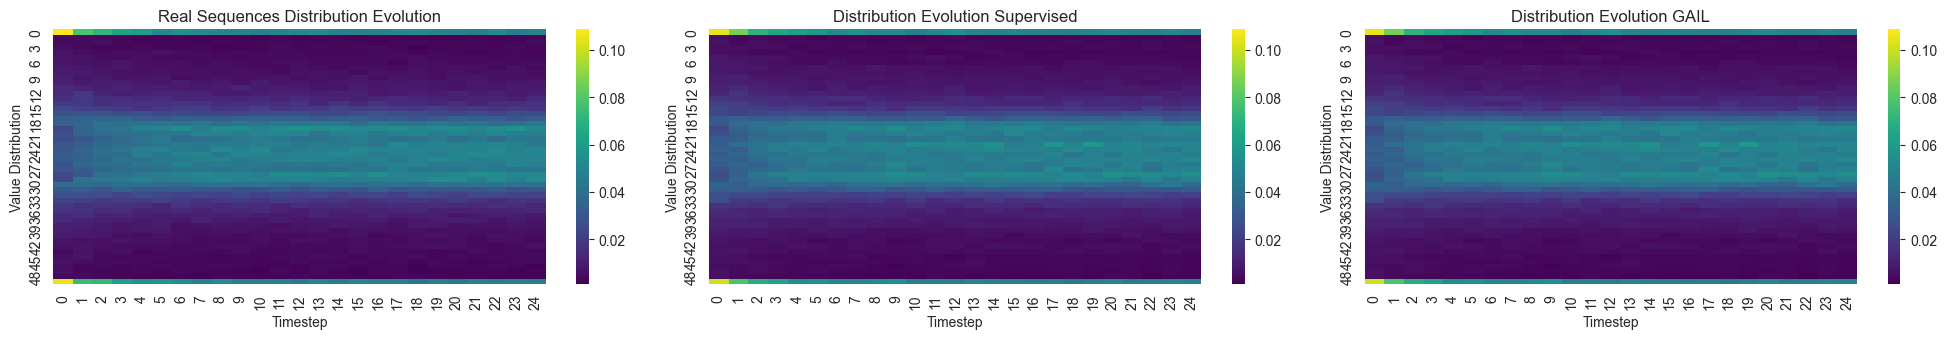

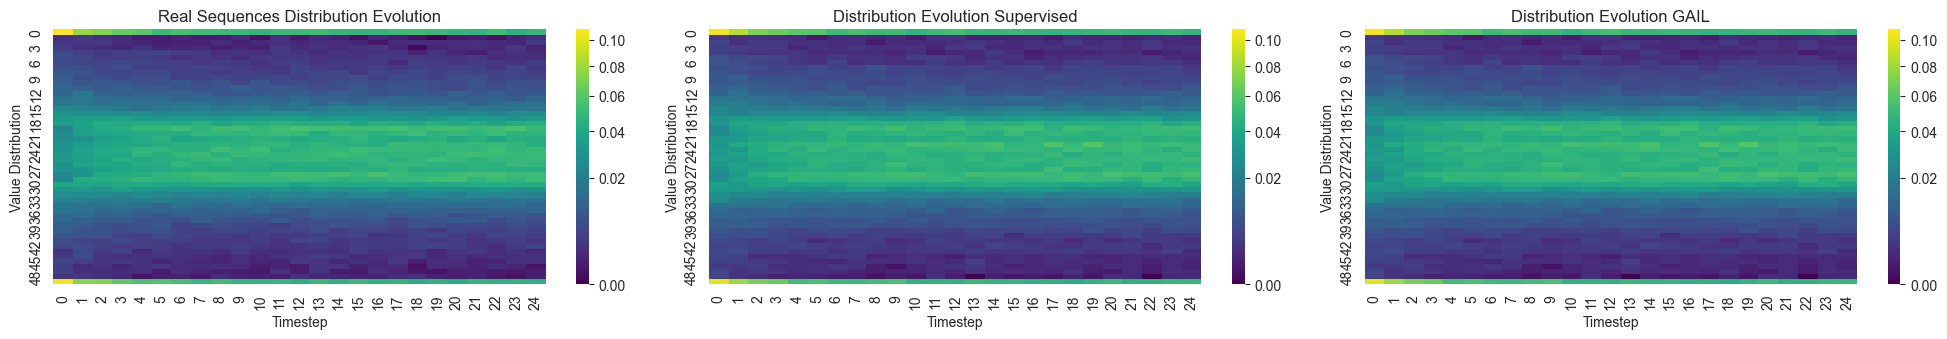

In [176]:
plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew)

plot_sequences(val_data[:,1:], supervised_data, supervised_data)
#plot_acf_pacf(val_data[:,1:], supervised_data, supervised_data)
wasserstein_dist(val_data[:,1:], supervised_data, supervised_data)
distribution_evolution(val_data[:,1:], supervised_data, supervised_data, token_size)
distribution_evolution1(val_data[:,1:], supervised_data, supervised_data, token_size)

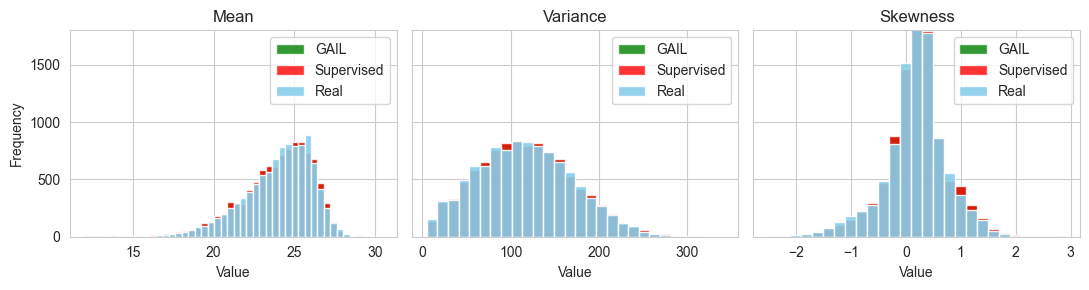

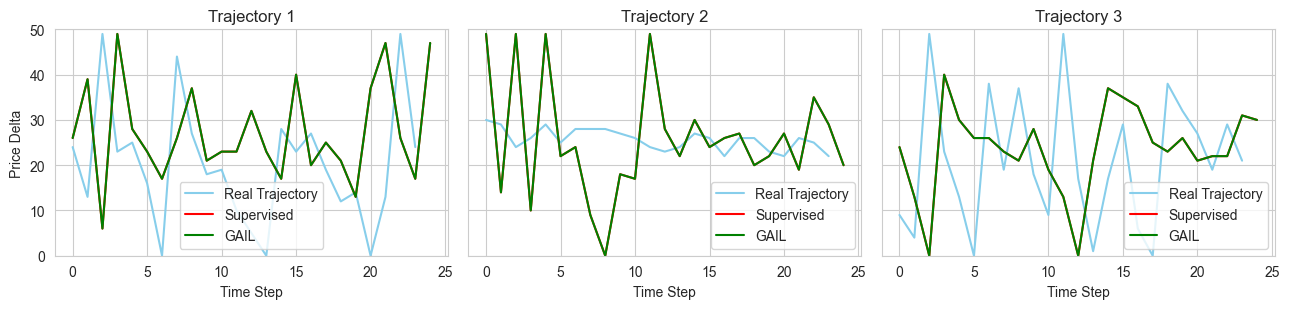

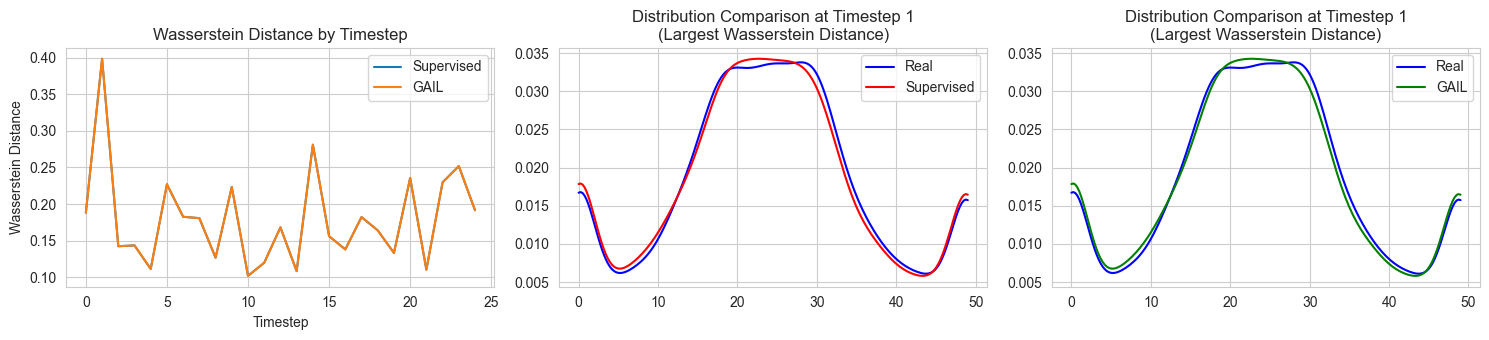

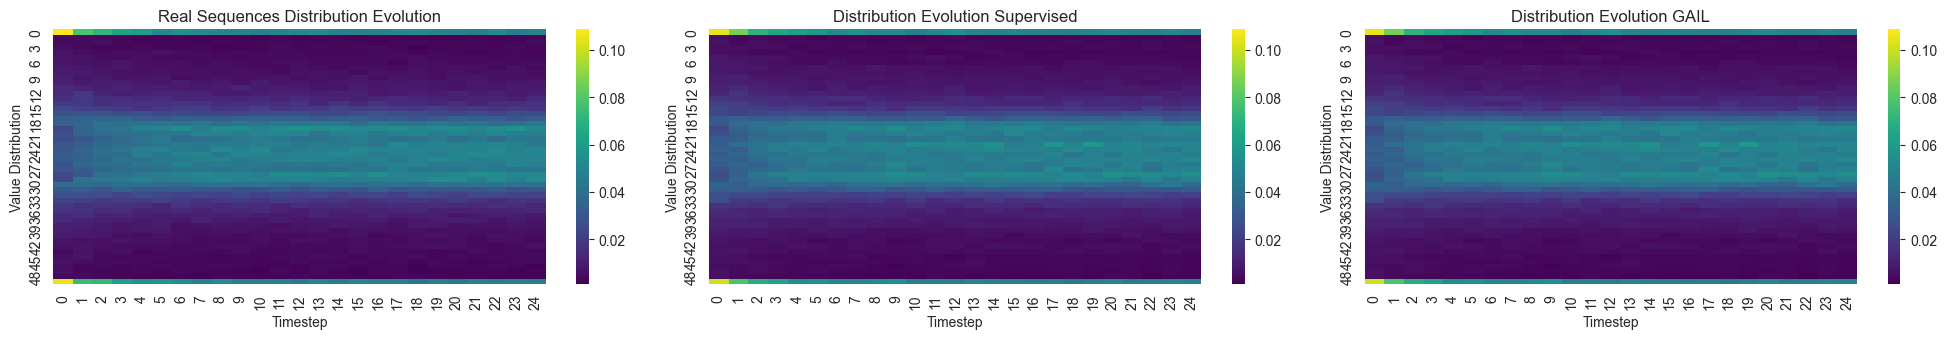

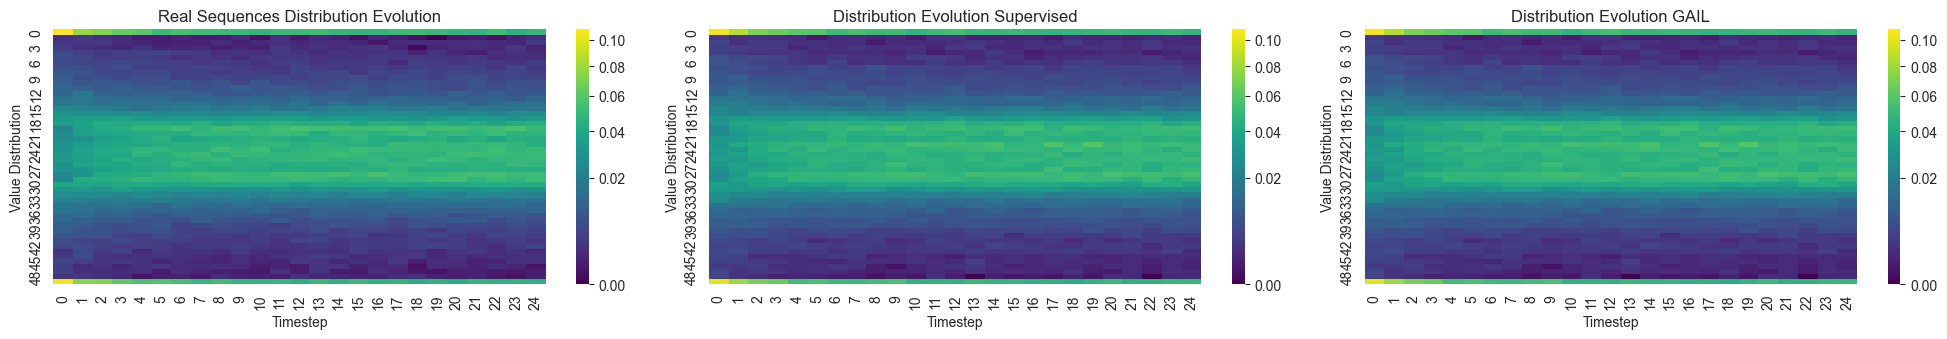

In [ ]:
plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew)

plot_sequences(val_data[:,1:], supervised_data, supervised_data)
#plot_acf_pacf(val_data[:,1:], supervised_data, supervised_data)
wasserstein_dist(val_data[:,1:], supervised_data, supervised_data)
distribution_evolution(val_data[:,1:], supervised_data, supervised_data, token_size)
distribution_evolution1(val_data[:,1:], supervised_data, supervised_data, token_size)